In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

# Preprocessing Data

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

#Instead of imputing missing values we replace them with predictions from the Decision tree
#https://www.kaggle.com/code/thomaskonstantin/analyzing-and-modeling-stroke-data/notebook

def fill_na_BMI(df: pd.DataFrame):

    DT_bmi_pipe = Pipeline( steps=[ 
                                ('scale',StandardScaler()),
                                ('lr',DecisionTreeRegressor(random_state=42))
                                ])

    #Predict BMI values using age, gender and hypertension                            
    X = df[['age','gender','hypertension','bmi']].copy()
    X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

    Missing = X[X.bmi.isna()]
    X = X[~X.bmi.isna()]
    Y = X.pop('bmi')
    DT_bmi_pipe.fit(X,Y)

    #Replace missing data with predicted values
    predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender','hypertension']]),index=Missing.index)
    df.loc[Missing.index,'bmi'] = predicted_bmi

fill_na_BMI(df)

In [5]:
df['ever_married'] = np.where(df.ever_married == 'Yes', 1, 0)

In [6]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,1,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,1,Self-employed,Rural,202.21,28.818919,never smoked,1
2,31112,Male,80.0,0,1,1,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,1,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,1,Self-employed,Rural,174.12,24.000000,never smoked,1


# Exploratory analysis

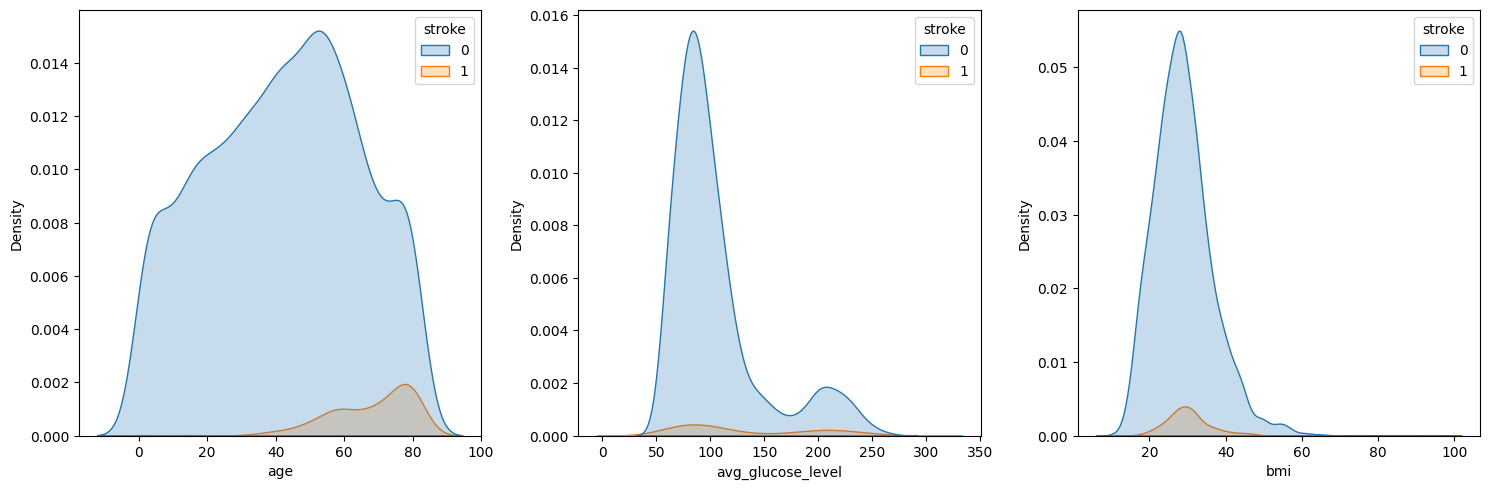

In [45]:
fig, ax = plt.subplots(1,3)
sns.kdeplot(df, x='age', fill=True, hue='stroke', ax=ax[0])
sns.kdeplot(df, x='avg_glucose_level', fill=True, hue='stroke',ax=ax[1])
sns.kdeplot(df, x='bmi', fill=True, hue='stroke',ax=ax[2])
fig.set_size_inches(15,5)
fig.tight_layout()


<AxesSubplot: xlabel='count', ylabel='stroke'>

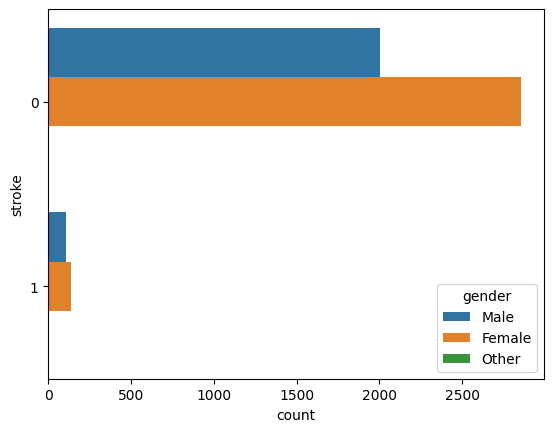

In [63]:
sns.countplot(df, y='stroke',hue='gender')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


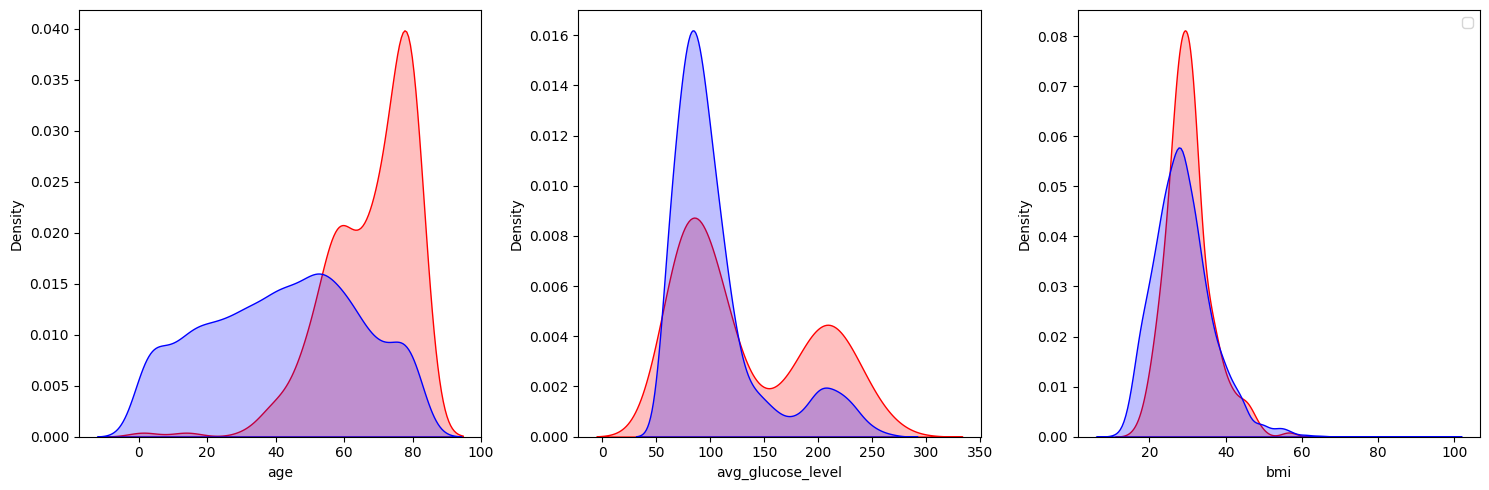

In [79]:
df_stroke = df[df.stroke==1]
df_no_stroke = df[df.stroke==0]

fig, ax = plt.subplots(1,3)
sns.kdeplot(df_stroke, x='age', fill=True, color='red', ax=ax[0])
sns.kdeplot(df_no_stroke, x='age', fill=True, color='blue', ax=ax[0])
plt.legend()
sns.kdeplot(df_stroke, x='avg_glucose_level', fill=True, color='red',ax=ax[1])
sns.kdeplot(df_no_stroke, x='avg_glucose_level', fill=True, color='blue',ax=ax[1])

sns.kdeplot(df_stroke, x='bmi', fill=True, color='red',ax=ax[2])
sns.kdeplot(df_no_stroke, x='bmi', fill=True, color='blue',ax=ax[2])

plt.legend()

fig.set_size_inches(15,5)
fig.tight_layout()

# Strokes in each smoking group

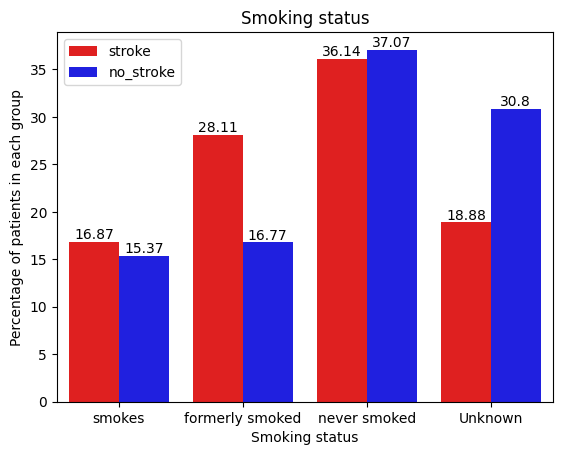

In [155]:
smoking_strokes = pd.DataFrame(df_stroke.smoking_status.value_counts()/sum(df_stroke.smoking_status.value_counts())*100)
smoking_no_strokes = pd.DataFrame(df_no_stroke.smoking_status.value_counts()/sum(df_no_stroke.smoking_status.value_counts())*100)

smoking_percentages = pd.DataFrame()
smoking_percentages['stroke'] = smoking_strokes
smoking_percentages['no_stroke'] = smoking_no_strokes
smoking_percentages.reset_index(inplace=True)
smoking_percentages.rename(columns={'index': 'status'}, inplace=True)

smoking_percentages_melted = smoking_percentages.melt(id_vars='status')
smoking_percentages_melted['value'] = smoking_percentages_melted['value'].round(2)

ordering = ['smokes','formerly smoked','never smoked','Unknown']
ax = sns.barplot(smoking_percentages_melted, x='status',y='value',hue='variable',errwidth=0,palette=['red','blue'],order=ordering)
plt.ylabel('Percentage of patients in each group')
plt.xlabel('Smoking status')
for i in ax.containers:
    ax.bar_label(i,)

plt.title('Smoking status')
plt.legend(loc='upper left')

# Strokes in each working group

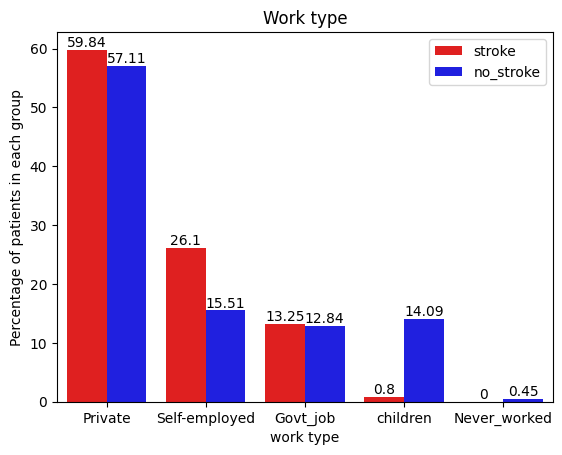

In [230]:
work_strokes = pd.DataFrame(df_stroke.work_type.value_counts()/sum(df_stroke.work_type.value_counts())*100)
work_strokes.loc['Never_worked'] = 0
work_no_strokes = pd.DataFrame(df_no_stroke.work_type.value_counts()/sum(df_no_stroke.work_type.value_counts())*100)

work_percentages = pd.DataFrame()
work_percentages['stroke'] = work_strokes
work_percentages['no_stroke'] = work_no_strokes
work_percentages.reset_index(inplace=True)
work_percentages.rename(columns={'index': 'type'}, inplace=True)

work_percentages_melted = work_percentages.melt(id_vars='type')
work_percentages_melted['value'] = work_percentages_melted['value'].round(2)


ax = sns.barplot(work_percentages_melted, x='type',y='value',hue='variable',errwidth=0,palette=['red','blue'])
plt.ylabel('Percentage of patients in each group')
plt.xlabel('work type')
for i in ax.containers:
    ax.bar_label(i,)

plt.title('Work type')
plt.legend(loc='upper right')

# Stroke by residence type, married status, hypertension and heart disease (0,1 variables)

matplotlib.axes._subplots.AxesSubplot

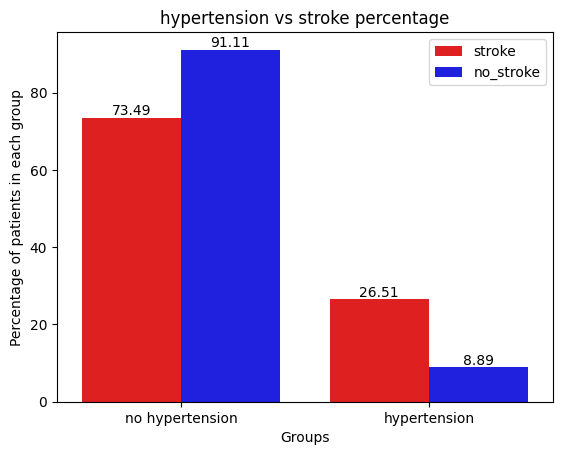

In [206]:
# fig, ax = plt.subplots(2,2)

def plot_percentages(series, title, xticks=None, legend_loc = 'best'):
    strokes = pd.DataFrame(df_stroke[series].value_counts()/sum(df_stroke[series].value_counts())*100)
    no_strokes = pd.DataFrame(df_no_stroke[series].value_counts()/sum(df_no_stroke[series].value_counts())*100)

    percentages = pd.DataFrame()
    percentages['stroke'] = strokes
    percentages['no_stroke'] = no_strokes
    percentages.reset_index(inplace=True)
    percentages.rename(columns={'index': 'type'}, inplace=True)

    percentages_melted = percentages.melt(id_vars='type')
    percentages_melted['value'] = percentages_melted['value'].round(2)

    ax = sns.barplot(percentages_melted, x='type',y='value',hue='variable',errwidth=0,palette=['red','blue'])
    plt.ylabel('Percentage of patients in each group')
    plt.xlabel('Groups')

    if xticks is not None:
        ax.set_xticklabels(xticks)
    for i in ax.containers:
        ax.bar_label(i,)

    plt.title(title)

    if legend_loc is not None:
        plt.legend(loc=legend_loc)
    else:
        ax.get_legend().remove()

    return ax

type(plot_percentages('hypertension','hypertension vs stroke percentage',['no hypertension','hypertension']))

<AxesSubplot: title={'center': 'residence type vs stroke percentage'}, xlabel='Groups', ylabel='Percentage of patients in each group'>

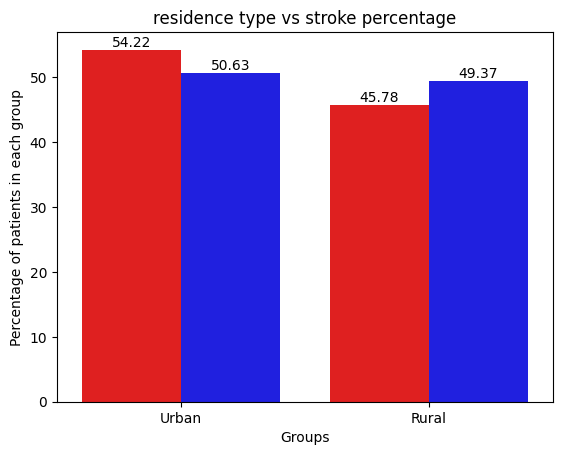

In [195]:
plot_percentages('Residence_type','residence type vs stroke percentage',legend_loc=None)

<AxesSubplot: title={'center': 'Marriage status vs stroke percentage'}, xlabel='Groups', ylabel='Percentage of patients in each group'>

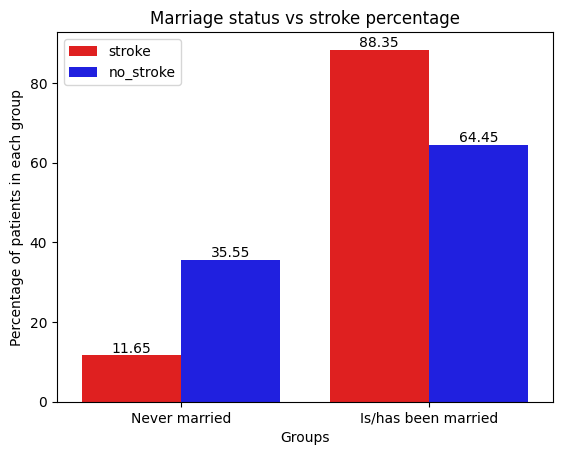

In [196]:
plot_percentages('ever_married','Marriage status vs stroke percentage',['Never married','Is/has been married'],legend_loc='upper left')

<AxesSubplot: title={'center': 'Heart disease vs stroke percentage'}, xlabel='Groups', ylabel='Percentage of patients in each group'>

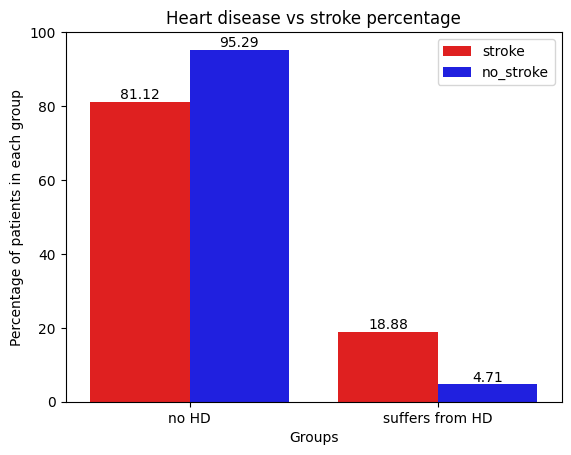

In [200]:
plot_percentages('heart_disease','Heart disease vs stroke percentage',['no HD','suffers from HD'],legend_loc='upper right')

# Pairwise correlation in data

<AxesSubplot: >

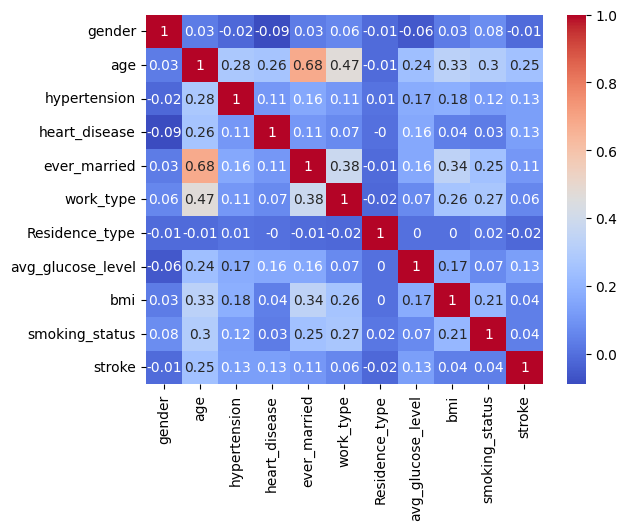

In [36]:
corr_mtx = df.iloc[:,1:].corr()
sns.heatmap(corr_mtx.round(2),cmap='coolwarm',annot=True)

# refactoring data for better ML results

In [7]:
#Convert all categorical data to numeric

df['gender'] = df.gender.replace({'Male': 0, 'Female': 1, 'Other': -1})
df['work_type'] = df.work_type.replace({'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'Never_worked': 3, 'children': -1})
df['Residence_type'] = df.Residence_type.replace({'Urban': 0, 'Rural': 1})
df['smoking_status'] = df.smoking_status.replace({'smokes': 0, 'formerly smoked': 1, 'never smoked': 2, 'Unknown': -1})

df.dtypes

id                     int64
gender                 int64
age                  float64
hypertension           int64
heart_disease          int64
ever_married           int32
work_type              int64
Residence_type         int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int64
stroke                 int64
dtype: object

In [8]:
#Prepare the training and testing sets

from sklearn.model_selection import train_test_split

random_state = 42

X = df.loc[:, df.columns != 'stroke']
X = X.drop(columns='id')

y=df.loc[:,'stroke']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=random_state)

In [9]:
#Removing the bias of small number of stroke positive patients

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=random_state)

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

new_df = X_train_sm
new_df['stroke'] = y_train_sm


X_train = X_train_sm.iloc[:, :-1]
y_train = y_train_sm



# Model Preparation

In [66]:
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split


lr_pipeline = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(random_state=random_state))])
svc_pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC(random_state=random_state, probability=True))])
random_forest_pipeline = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier(random_state=random_state))])

In [74]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import recall_score

In [68]:
#F1 scores - recall and precision overall

lr_cv_score = cross_val_score(lr_pipeline,X_train,y_train, cv=10,scoring='f1').mean()
svc_cv_score = cross_val_score(svc_pipeline,X_train,y_train, cv=10,scoring='f1').mean()
rf_cv_score = cross_val_score(random_forest_pipeline,X_train,y_train, cv=10,scoring='f1').mean()

print(f'Average F1 score of the LogisticRegression model: {lr_cv_score}')
print(f'Average F1 score of the SVC model: {svc_cv_score}')
print(f'Average F1 score of the Random Forest model: {rf_cv_score}')


Average F1 score of the LogisticRegression model: 0.8268915657602557
Average F1 score of the SVC model: 0.8697600548804338
Average F1 score of the Random Forest model: 0.9505423240933648


In [75]:
#Accuracy score - correct predictions

lr_pipeline.fit(X_train,y_train)
y_pred = lr_pipeline.predict(X_test)
lr_acc_score = accuracy_score(y_test,y_pred)

svc_pipeline.fit(X_train,y_train)
y_pred = svc_pipeline.predict(X_test)
svc_acc_score = accuracy_score(y_test,y_pred)

random_forest_pipeline.fit(X_train,y_train)
y_pred = random_forest_pipeline.predict(X_test)
rf_acc_score = accuracy_score(y_test,y_pred)



print(f'Average Acc. score of the LogisticRegression model: {lr_acc_score}')
print(f'Average Acc. score of the SVC model: {svc_acc_score}')
print(f'Average Acc. score of the Random Forest model: {rf_acc_score}')

Average Acc. score of the LogisticRegression model: 0.8127853881278538
Average Acc. score of the SVC model: 0.8343118069145466
Average Acc. score of the Random Forest model: 0.9145466405740378


In [76]:
#Recall scores

lr_pipeline.fit(X_train,y_train)
y_pred = lr_pipeline.predict(X_test)
lr_rec_score = recall_score(y_test,y_pred)

svc_pipeline.fit(X_train,y_train)
y_pred = svc_pipeline.predict(X_test)
svc_rec_score = recall_score(y_test,y_pred)

random_forest_pipeline.fit(X_train,y_train)
y_pred = random_forest_pipeline.predict(X_test)
rf_rec_score = recall_score(y_test,y_pred)

print(f'Average recall score of the LogisticRegression model: {lr_rec_score}')
print(f'Average recall score of the SVC model: {svc_rec_score}')
print(f'Average recall score of the Random Forest model: {rf_rec_score}')


Average recall score of the LogisticRegression model: 0.5393258426966292
Average recall score of the SVC model: 0.4157303370786517
Average recall score of the Random Forest model: 0.16853932584269662


Text(0.5, 1.0, 'Confusion matrix for Logistic Regression model')

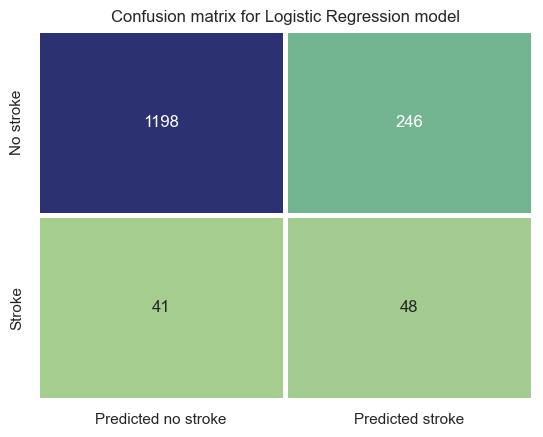

In [70]:
#Confusion matrix for each base model

#Logistic Regression
lr_pipeline.fit(X_train,y_train)
y_pred = lr_pipeline.predict(X_test)
lr_confusion_mtx = confusion_matrix(y_test,y_pred)

sns.heatmap(lr_confusion_mtx,fmt='.0f', annot=True,cmap='crest',xticklabels=['Predicted no stroke', 'Predicted stroke'], yticklabels=['No stroke','Stroke'],cbar=False, linewidths=2.5)
plt.title("Confusion matrix for Logistic Regression model")

Text(0.5, 1.0, 'Confusion matrix for SVC model')

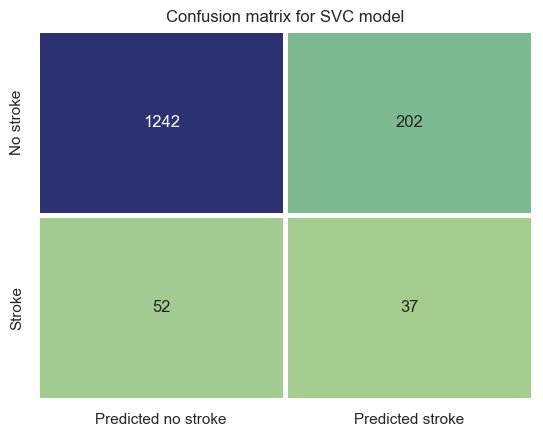

In [71]:
#SVC
svc_pipeline.fit(X_train,y_train)
y_pred = svc_pipeline.predict(X_test)
svc_confusion_mtx = confusion_matrix(y_test,y_pred)

sns.heatmap(svc_confusion_mtx,fmt='.0f', annot=True,cmap='crest',xticklabels=['Predicted no stroke', 'Predicted stroke'], yticklabels=['No stroke','Stroke'],cbar=False, linewidths=2.5)
plt.title("Confusion matrix for SVC model")

Text(0.5, 1.0, 'Confusion matrix for random_forest model')

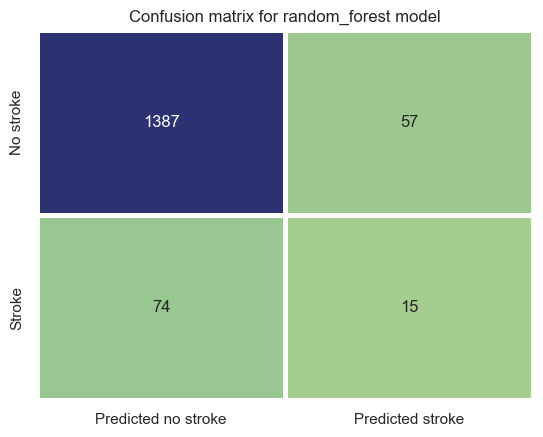

In [72]:
#Random forest
random_forest_pipeline.fit(X_train,y_train)
y_pred = random_forest_pipeline.predict(X_test)
random_forest_confusion_mtx = confusion_matrix(y_test,y_pred)

sns.heatmap(random_forest_confusion_mtx,fmt='.0f', annot=True,cmap='crest',xticklabels=['Predicted no stroke', 'Predicted stroke'], yticklabels=['No stroke','Stroke'],cbar=False, linewidths=2.5)
plt.title("Confusion matrix for random_forest model")

# ROC AUC plots and scores

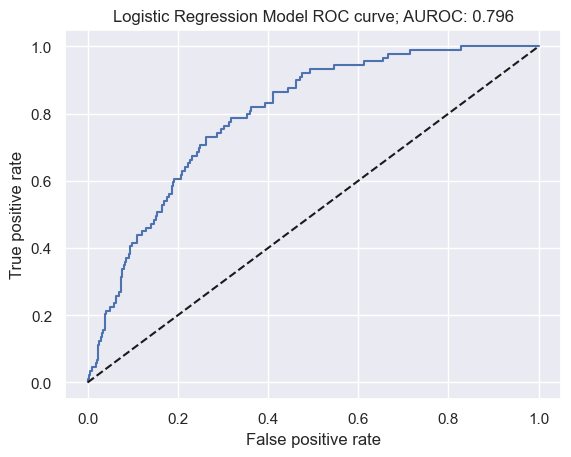

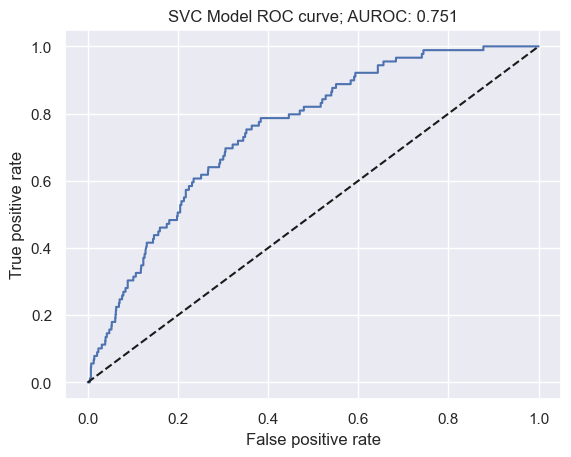

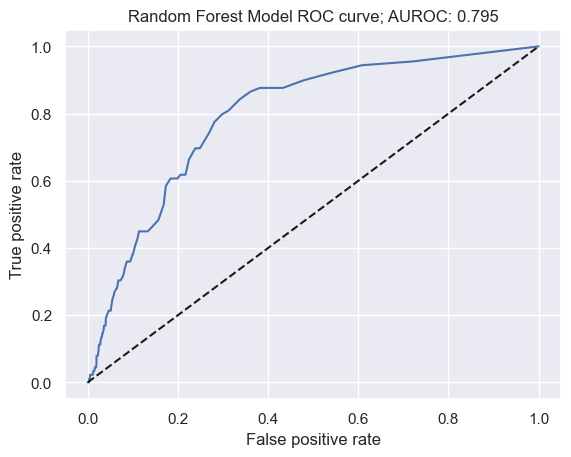

In [79]:
def ROC_compare(model, X_test,y_test,figname,modelname):

    y_pred_proba = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)


    sns.set()

    plt.plot(fpr, tpr)

    plt.plot(fpr, fpr, linestyle = '--', color = 'k')

    plt.xlabel('False positive rate')

    plt.ylabel('True positive rate')

    AUROC = np.round(roc_auc_score(y_test, y_pred_proba), 3)

    plt.title(f'{modelname} Model ROC curve; AUROC: {AUROC}');
    plt.savefig(figname)
    plt.show()

    return roc_auc_score(y_test, y_pred_proba)

lr_auc_score = ROC_compare(lr_pipeline,X_test,y_test,'ROC_AUC_LogReg.png','Logistic Regression')
svc_auc_score = ROC_compare(svc_pipeline,X_test,y_test,'ROC_AUC_SVC.png','SVC')
rf_auc_score = ROC_compare(random_forest_pipeline,X_test,y_test,'ROC_AUC_RandomForest.png','Random Forest')

Text(0.5, 1.0, 'Selected performance metrics for base models')

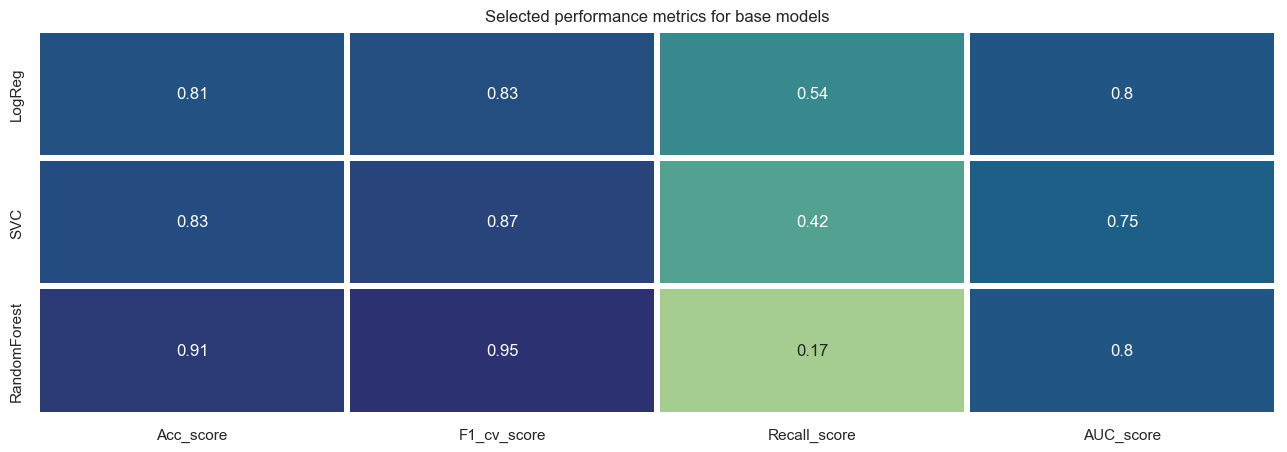

In [92]:
#Summary statistics for all models

logreg_stats = [lr_acc_score,lr_cv_score,lr_rec_score,lr_auc_score]
svc_stats = [svc_acc_score,svc_cv_score,svc_rec_score,svc_auc_score]
rf_stats = [rf_acc_score,rf_cv_score,rf_rec_score,rf_auc_score]

stats= [logreg_stats,svc_stats,rf_stats]
df_stats = pd.DataFrame(stats, columns =['Acc_score', 'F1_cv_score','Recall_score','AUC_score'])
df_stats.index = ['LogReg','SVC','RandomForest']

plt.figure(figsize = (16,5))
sns.heatmap(df_stats, cmap='crest',annot=True,cbar=False,linewidth=3)
plt.title('Selected performance metrics for base models')

# Tuning of the selected models

In [ ]:
from sklearn.model_selection import GridSearchCV

# X_test, X_train, y_test, y_train

#From this point onward we drop the poorly performing SVC model (bad accuracy and recall)

#Logistic Regression parameter tuning

logreg = LogisticRegression(random_state=random_state)
logreg.get_params()
# {'C': 1.0,
#  'class_weight': None,
#  'dual': False,
#  'fit_intercept': True,
#  'intercept_scaling': 1,
#  'l1_ratio': None,
#  'max_iter': 100,
#  'multi_class': 'auto',
#  'n_jobs': None,
#  'penalty': 'l2',
#  'random_state': None,
#  'solver': 'lbfgs',
#  'tol': 0.0001,
#  'verbose': 0,
#  'warm_start': False}

param_grid = {'C':[1,2,3,5], 'penalty':['l1','l2',None,'elasticnet'],'max_iter':[100,200,300],'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

lr_grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid)
lr_grid_search.fit(X_train,y_train)
lr_grid_search.best_estimator_

In [103]:
lr_grid_search.best_params_

{'C': 5, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

In [116]:
logreg_best_model = lr_grid_search.best_estimator_

In [113]:
#Random Forest parameter tuning

rf = RandomForestClassifier(random_state=random_state)
rf.get_params()
# {'bootstrap': True,
#  'ccp_alpha': 0.0,
#  'class_weight': None,
#  'criterion': 'gini',
#  'max_depth': None,
#  'max_features': 'sqrt',
#  'max_leaf_nodes': None,
#  'max_samples': None,
#  'min_impurity_decrease': 0.0,
#  'min_samples_leaf': 1,
#  'min_samples_split': 2,
#  'min_weight_fraction_leaf': 0.0,
#  'n_estimators': 100,
#  'n_jobs': None,
#  'oob_score': False,
#  'random_state': 42,
#  'verbose': 0,
#  'warm_start': False}

param_grid = {'n_estimators': [100,200], 'criterion': ['gini','entropy','log_loss'], 'max_depth':[None,3,5,7], 'min_samples_split': [2,3],
 'max_features':['sqrt','log2',None], 'oob_score': [True,False]}

rf_grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,verbose=3)
rf_grid_search.fit(X_train,y_train)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV 1/5] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, oob_score=True;, score=0.905 total time=   0.9s
[CV 2/5] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, oob_score=True;, score=0.961 total time=   0.8s
[CV 3/5] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, oob_score=True;, score=0.956 total time=   0.7s
[CV 4/5] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, oob_score=True;, score=0.963 total time=   0.7s
[CV 5/5] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, oob_score=True;, score=0.963 total time=   0.7s
[CV 1/5] END criterion=gini, max_depth=None, max_features=sqrt, min_samples_split=2, n_estimators=100, oob_score=False;, score=0.905 total time=   0.7s
[CV 2/5] END criterion=gini, 

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 3, 5, 7],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_split': [2, 3],
                         'n_estimators': [100, 200],
                         'oob_score': [True, False]},
             verbose=3)

In [117]:
rf_best_model = rf_grid_search.best_estimator_

In [115]:
rf_grid_search.best_params_
# {'criterion': 'gini',
#  'max_depth': None,
#  'max_features': 'sqrt',
#  'min_samples_split': 2,
#  'n_estimators': 200,
#  'oob_score': True}

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 200,
 'oob_score': True}

In [121]:
#The best models

logreg_best_model
rf_best_model

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

# Feature importance

In [141]:
def plot_Feature_importance(feature_imp):

    feature_importance = abs(feature_imp)
    feature_importance = 100.0 * (feature_importance / feature_importance.max())

    sorted_idx = feature_importance.argsort()
    sorted_idx

    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure()
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
    featax.set_xlabel('Relative Feature Importance')

    plt.tight_layout()   
    plt.show()

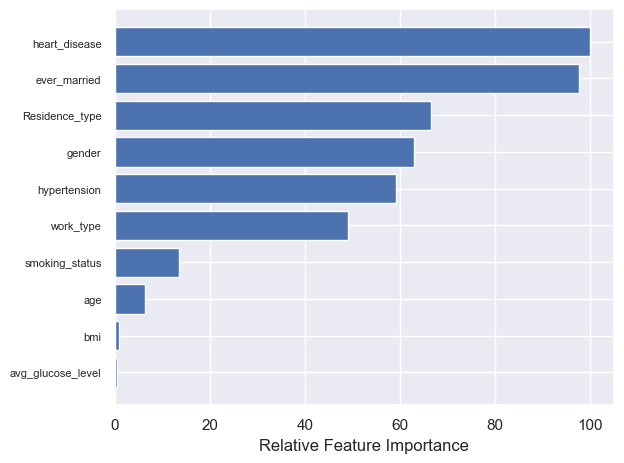

In [142]:
plot_Feature_importance(logreg_best_model.coef_[0])

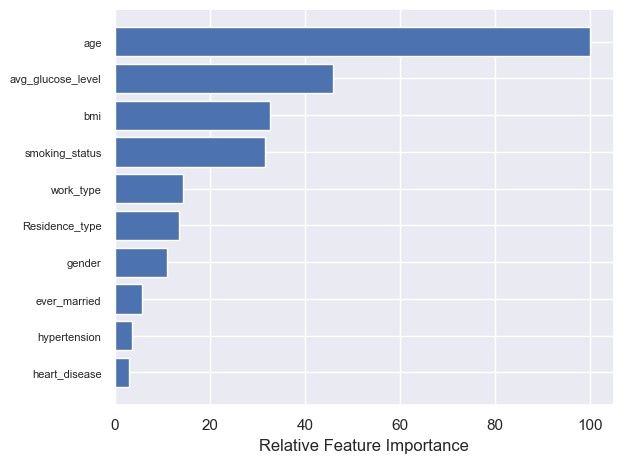

In [143]:
plot_Feature_importance(rf_best_model.feature_importances_)